**Note:** The overall face morphing process will takes about 50min.

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib
from scipy.spatial import Delaunay

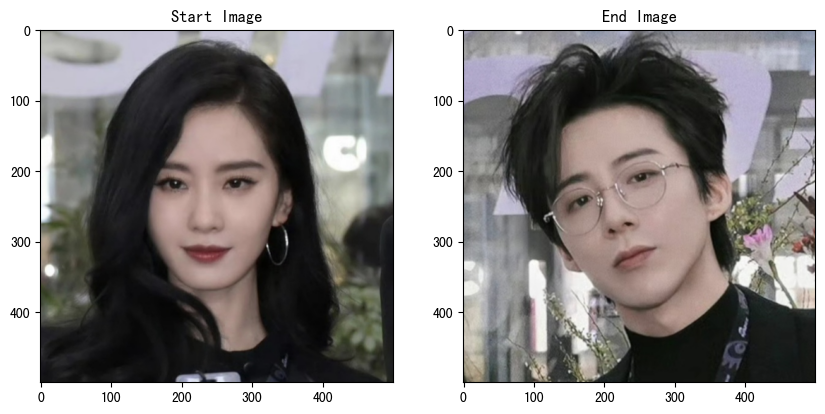

In [289]:
# load face images
start_image_path = './images/lss.jpg'
end_image_path = './images/lyn.jpg'

start_image = cv2.imread(start_image_path)
start_image = cv2.cvtColor(start_image, cv2.COLOR_BGR2RGB)
end_image = cv2.imread(end_image_path)
end_image = cv2.cvtColor(end_image, cv2.COLOR_BGR2RGB)
# resize image for shorter execution time
start_image = cv2.resize(start_image, (500, 500))
end_image = cv2.resize(end_image, (500, 500))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(start_image)
plt.title('Start Image')
plt.subplot(1, 2, 2)
plt.imshow(end_image)
plt.title('End Image')
plt.show()

In [290]:
# Functions in imutils/face_utils (https://github.com/PyImageSearch/imutils/blob/master/imutils/face_utils/helpers.py)
def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it to the format (x, y, w, h) as we would normally do with OpenCV
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y

    # return a tuple of (x, y, w, h)
    return (x, y, w, h)

def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((shape.num_parts, 2), dtype=dtype)

    # loop over all facial landmarks and convert them to a 2-tuple of (x, y)-coordinates
    for i in range(0, shape.num_parts):
        coords[i] = (shape.part(i).x, shape.part(i).y)

    # return the list of (x, y)-coordinates
    return coords

In [291]:
# Find face landmarks
def detect_face_landmarks(image):
    # Initialize dlib's face detector (HOG-based)
    detector = dlib.get_frontal_face_detector()
    
    # Creat the facial landmark predictor
    predictor_path = "shape_predictor_68_face_landmarks.dat"
    predictor = dlib.shape_predictor(predictor_path)
    
    # Convert rgb image to gray scale image (computational effectiveness & focus on structure and texture rather than color)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Detect faces
    rects = detector(gray_image)
    
    # store face info
    faces_info = []
    
    # Loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region
        # convert the facial landmark (x, y)-coordinates to a NumPy array
        shape = predictor(gray_image, rect)
        shape = shape_to_np(shape)
        faces_info.append({"rect": rect, "shape": shape})
    
    # add border landmarks
    height, width = gray_image.shape
    border = []
    border.append([0, 0])                       # top-left corner
    border.append([0, width - 1])               # top-right corner
    border.append([height - 1, 0])              # bottom-left corner
    border.append([height - 1, width - 1])      # bottom-right corner
    step = 3
    for i in range(1, step):
        if [0, int(i/step*width)] not in border:
            border.append([0, int(i/step*width)])
        if [height - 1, int(i/step*width)] not in border:
            border.append([height - 1, int(i/step*width)])
    for j in range(1, step):
        if [int(j/step*height), 0] not in border:
            border.append([int(j/step*height), 0])
        if [int(j/step*height), width - 1] not in border:
            border.append([int(j/step*height), width - 1])
        
    faces_info.append({"shape": np.array(border)})
    
    return faces_info

In [292]:
# get detected face region & landmarks
faces_info_start_image = detect_face_landmarks(start_image)
landmarks_start_image = np.concatenate((faces_info_start_image[1]['shape'], faces_info_start_image[0]['shape']), axis=0)

faces_info_end_image = detect_face_landmarks(end_image)
landmarks_end_image = np.concatenate((faces_info_end_image[1]['shape'], faces_info_end_image[0]['shape']), axis=0)

In [293]:
# Show the result of face detections + facial landmarks
def draw_landmarks(image, faces_info):
    # create copy of input image to avoid modify
    drawn_image = image.copy()
    # for each detected face in the image (only one face per image in this coursework)
    for face_info in faces_info:
#         rect = face_info['rect']
        shape = face_info['shape']
        # convert dlib's rectangle to a OpenCV-style bounding box [i.e., (x, y, w, h)]
#         (x, y, w, h) = rect_to_bb(rect)
        # draw the face bounding box
#         cv2.rectangle(drawn_image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        # draw facial landmarks
        for (x, y) in shape:
            cv2.circle(drawn_image, (x, y), 3, (255, 0, 0), -1)
    return drawn_image

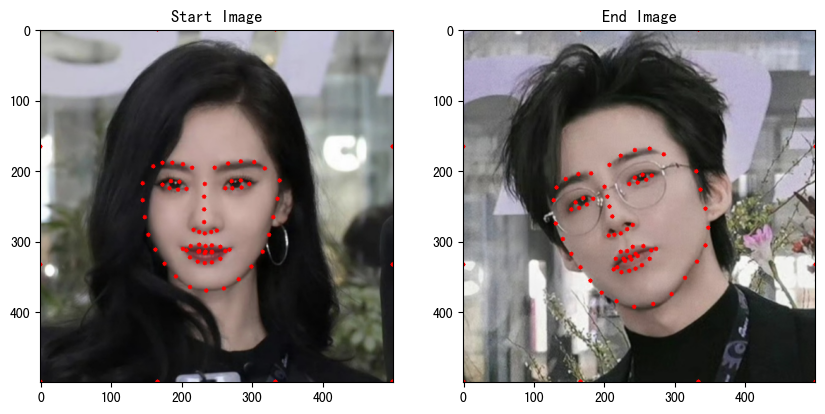

In [294]:
# draw
detected_start_image = draw_landmarks(start_image, faces_info_start_image)
detected_end_image = draw_landmarks(end_image, faces_info_end_image)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(detected_start_image)
plt.title('Start Image')
plt.subplot(1, 2, 2)
plt.imshow(detected_end_image)
plt.title('End Image')
plt.show()

In [295]:
# get triangulation indices by appling Delaunay triangulation on one image
# make sure the order of the triangles and the vertices should reflect the correspondences between triangles and vertices.

# create Delaunay triangulation
triangulation = Delaunay(landmarks_start_image)
# get indices of triangular vertices
triangles = triangulation.simplices

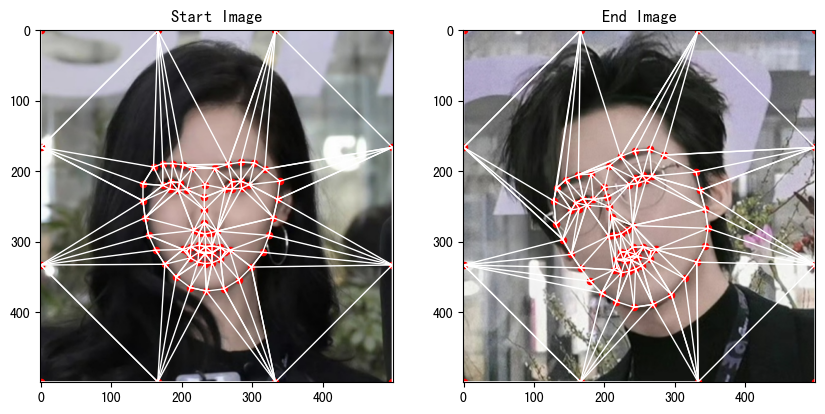

In [296]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
# show image
plt.imshow(start_image)
# draw triangulations
for simplex in triangles:
    plt.plot(landmarks_start_image[simplex, 0], landmarks_start_image[simplex, 1], color='white', linewidth=1)
# draw landmarks
plt.scatter(landmarks_start_image[:, 0], landmarks_start_image[:, 1], c='r', marker='o', s=20)
plt.title('Start Image')

plt.subplot(1, 2, 2)
# show image
plt.imshow(end_image)
# draw triangulations
for simplex in triangles:
    plt.plot(landmarks_end_image[simplex, 0], landmarks_end_image[simplex, 1], color='white', linewidth=1)
# draw landmarks
plt.scatter(landmarks_end_image[:, 0], landmarks_end_image[:, 1], c='r', marker='o', s=20)
plt.title('End Image')

plt.show()

In [297]:
def interpolate_coordinates(start_coordinates, end_coordinates, num_frames):
    # create a list to store intermediate coordinates at each frame
    intermediate_coordinates = []
    for frame in range(num_frames):
        # calculate interpolation weights
        w = frame / (num_frames - 1)
        # linear interpolation
        new_coords = (1 - w) * start_coordinates + w * end_coordinates
        intermediate_coordinates.append(new_coords)
    return np.array(intermediate_coordinates)

In [305]:
# interpolate intermediate landmarks
num_frames = 50
landmarks_all_frames = interpolate_coordinates(landmarks_start_image, landmarks_end_image, num_frames)

In [306]:
def computeAffineWarp(start_triangle_coords, end_triangle_coords):
    # append a column of ones for translation term
    A = np.column_stack([start_triangle_coords, np.ones(start_triangle_coords.shape[0])])
    B = np.column_stack([end_triangle_coords, np.ones(end_triangle_coords.shape[0])])
    affine_matrix = np.linalg.inv(A.T @ A) @ A.T @ B
    return affine_matrix

In [307]:
def applyAffineWarp(points, affine_matrix):
    # append a column of ones for translation term
    start_coords = np.column_stack([points, np.ones(points.shape[0])])
    end_coords = start_coords @ affine_matrix
    return end_coords[:, :-1]

In [308]:
def bilinear_interpolation(img, point):
    height, width = img.shape[:2]
    
    # notice the order of x&y!!!
    x, y = point[1], point[0]

    # make sure the coordinates are within valid image range
    x = np.clip(x, 0, width - 1)
    y = np.clip(y, 0, height - 1)

    # get 4 neighbors
    x0, y0 = np.floor(x).astype(int), np.floor(y).astype(int)
    x1, y1 = x0 + 1, y0 + 1
    
    # make sure the neighbors are within valid image range
    x0 = np.clip(x0, 0, width - 1)
    x1 = np.clip(x1, 0, width - 1)
    y0 = np.clip(y0, 0, height - 1)
    y1 = np.clip(y1, 0, height - 1)
    
    dx = x - x0
    dy = y - y0

    # bilinear interpolation equation
    interpolated_value = (1 - dx) * (1 - dy) * img[x0, y0] + dx * (1 - dy) * img[x1, y0] + (1 - dx) * dy * img[x0, y1] + dx * dy * img[x1, y1]

    return interpolated_value

In [309]:
def get_triangle_pixels(triangle):
    
    # generate bounding box of triangle
    xMin, yMin = np.floor(np.min(triangle, axis=0)).astype(int)
    xMax, yMax = np.ceil(np.max(triangle, axis=0)).astype(int)

    x_range = np.arange(xMin, xMax + 1)
    y_range = np.arange(yMin, yMax + 1)
    x, y = np.meshgrid(x_range, y_range)

    # points within the bounding box
    points = np.column_stack((x.ravel(), y.ravel()))

    # mask of points inside or on the given triangle
    mask = np.array([cv2.pointPolygonTest(triangle.astype(np.int32), (int(pt[0]), int(pt[1])), False) >= 0 for pt in points])

    return points[mask]

In [310]:
# check collinear situation
def are_points_collinear(points):
    
    matrix = np.column_stack([points, np.ones(points.shape[0])])
    
    # get determinant
    det = np.linalg.det(matrix)

    # if the det approach to 0, collinear (absolute tolerance is 1e-9)
    return np.isclose(det, 0)

In [311]:
height, width = start_image.shape[:2]

# Generate intermediate images
intermediate_images = []
intermediate_images.append(start_image)

for frame in range(1, num_frames):
    print(f"Processing the No.{frame} frame...")
    intermediate_image = np.zeros((height, width, 3))
    
    landmarks_current_frame = landmarks_all_frames[frame]
    landmarks_start_frame = landmarks_all_frames[0]
    landmarks_end_frame = landmarks_all_frames[-1]

    for simplex in triangles:
        # Compute affine transformation between triangle's corresponding indices
        # NOTE: from current triangle coords transform to initial & end one (inverse)
        start_triangle_coords = landmarks_current_frame[simplex]  # (3, 2)
        end_triangle_coords_1 = landmarks_start_frame[simplex]  # (3, 2)
        end_triangle_coords_2 = landmarks_end_frame[simplex]  # (3, 2)
        
        # when the image is small, there's a certain probability of getting collinear triangle vertices
        if not are_points_collinear(start_triangle_coords):
            affine_matrix_1 = computeAffineWarp(start_triangle_coords, end_triangle_coords_1)
            affine_matrix_2 = computeAffineWarp(start_triangle_coords, end_triangle_coords_2)
            # get points in the triangle simplex
            start_points = get_triangle_pixels(start_triangle_coords)
            # apply affine warp to the points
            end_points_1 = applyAffineWarp(start_points, affine_matrix_1)
            end_points_2 = applyAffineWarp(start_points, affine_matrix_2)

            # billinear interpolation to get pixel color in start & end frame
            # notice the order of (x, y) coordinates!!! X-Y format / R-C format
            for i, start_point in enumerate(start_points):
                color1 = bilinear_interpolation(start_image, end_points_1[i])
                color2 = bilinear_interpolation(end_image, end_points_2[i])
                # blending (cross dissolving)
                w = frame / (num_frames - 1)
                intermediate_image[start_point[1], start_point[0]] = (1 - w) * color1 + w * color2
    
    intermediate_images.append(intermediate_image)

Processing the No.1 frame...
Processing the No.2 frame...
Processing the No.3 frame...
Processing the No.4 frame...
Processing the No.5 frame...
Processing the No.6 frame...
Processing the No.7 frame...
Processing the No.8 frame...
Processing the No.9 frame...
Processing the No.10 frame...
Processing the No.11 frame...
Processing the No.12 frame...
Processing the No.13 frame...
Processing the No.14 frame...
Processing the No.15 frame...
Processing the No.16 frame...
Processing the No.17 frame...
Processing the No.18 frame...
Processing the No.19 frame...
Processing the No.20 frame...
Processing the No.21 frame...
Processing the No.22 frame...
Processing the No.23 frame...
Processing the No.24 frame...
Processing the No.25 frame...
Processing the No.26 frame...
Processing the No.27 frame...
Processing the No.28 frame...
Processing the No.29 frame...
Processing the No.30 frame...
Processing the No.31 frame...
Processing the No.32 frame...
Processing the No.33 frame...
Processing the No.3

In [312]:
# save frame sequences
output_folder = "./output_images"
os.makedirs(output_folder, exist_ok=True)

for i, image in enumerate(intermediate_images):
    filename = os.path.join(output_folder, f"frame_{i + 1:03d}.png")
    cv2.imwrite(filename, cv2.cvtColor(image.astype(np.uint8), cv2.COLOR_RGB2BGR))

In [313]:
# create a video for 50 image frames
image_folder = './output_images'
video_path = './video.mp4'

images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
images.sort()


frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width = frame.shape[:2]

# video encoder
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# video object
fps = 10
video = cv2.VideoWriter(video_path, fourcc, fps, (width, height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))
video.release()

print("Video created successfully!")

Video created successfully!
